In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
import seaborn as sns
import pandas as pd

In [5]:
dataset = pd.read_csv('yes25.csv')

In [6]:
test = dataset[dataset['month']==5]
train = dataset[dataset['month']!=5]
test.drop(['month'], axis = 1, inplace = True)
train.drop(['month'], axis = 1, inplace = True)

In [7]:
# get arms from dataset
train_arms = train.iloc[:,0].astype('int').values
# get rewards from dataset
train_rewards = train.iloc[:,1].astype('float').values
# get contexts from dataset 
train_contexts = train.iloc[:,2:].astype('float').values

In [8]:
# get arms from dataset
test_arms = test.iloc[:,0].astype('int').values
# get rewards from dataset
test_rewards = test.iloc[:,1].astype('float').values
# get contexts from dataset 
test_contexts = test.iloc[:,2:].astype('float').values

In [9]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [10]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    # basic input checks to ensure everything works after assertions are passed
    assert isinstance(mab,MAB), 'MAB instance required'
    assert type(arms) is np.ndarray, 'arms should be numpy array'
    assert type(rewards) is np.ndarray, 'rewards should be numpy array'
    assert type(contexts) is np.ndarray, 'contexts should be numpy array'
    if nrounds is not None:
        assert type(nrounds) is int, 'input type int required for nrounds'
        assert nrounds > 0, 'nrounds should be greater than 0'
    assert 'int' in str(arms.dtype), 'arms should be int numpy array'
    assert 'float' in str(rewards.dtype), 'rewards should be float numpy array'
    assert 'float' in str(contexts.dtype), 'contexts should be float numpy array'
    assert arms.ndim == 1, 'arms should be 1D numpy array (nevents,) '
    assert rewards.ndim == 1, 'rewards should be 1D numpy array (nevents,)'
    assert contexts.ndim == 2, 'contexts should be 2D numpy array (nevents, mab.narms*nfeatures)'
    
    ndims = mab.ndims
    
    # initially empty history
    history = []
    mean_array = np.zeros(shape=(nrounds, ndims))
    cov_array = np.zeros(shape=(nrounds,ndims,ndims))
    
    # initially empty payoff
    out = []
    
    # get total number of events
    T = arms.shape[0]
    
    # ensuring there are events to evaluate
    assert T > 0, "There are no events for offline evaluation"
    
    # initilize control parameters
    events_parsed = 0
    all_events_parsed = False
    
    # sequentially parse stream of events
    for t in range(0,T):
        
        # repeat until matching arm is found
        while(True):
            
            # if all events are parsed - stop processing
            if events_parsed == T:
                all_events_parsed = True
                break
            
            # Get next event    
            # get selected arm
            a = arms[events_parsed]
            # get observed payoff for the arm
            r_a = rewards[events_parsed]
            # get observed context for the arm
            context = contexts[events_parsed,:]
            
           
            
            # keeping track of parsed events
            events_parsed += 1
     
            # set required round on the basis of history recorded
            tround = len(history)+1
            # play arm for tround
            arm,mean,cov = mab.play(tround,context)
            mean_array[tround-1] = mean
            cov_array[tround-1] = cov
            # check if arm is matched or not
            if arm == a:
                # matching arm found - update played arm
                mab.update(arm,r_a,context)
                
                break 
        
        # check if all events are parsed       
        if all_events_parsed:
            # stop processing
            break
            
        # record event tuple in history for each matched round
        event = (tround,a,r_a,context)
        history.append(event)      

        # add observed payoff for the matched arm
        out.append(r_a)
        
        # check if required rounds are reached, if provided
        if nrounds is not None and len(history) == nrounds:
            break
    
    # return per round rewards recorded
    return out,mean_array,cov_array

In [11]:
# 소라 train_test
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
      
        # basic input checks
        assert type(narms) is int, 'input type int required for narms'
        assert type(ndims) is int, 'input type int required for ndims'
        assert type(v) is float, 'input type float required for v'
        assert narms > 0, "number of arms should be greater than 0"
        assert ndims > 0, "ndims should be greater than 0"
        assert v > 0, "v should be greater than 0"
        
        # initilize MAB parameters
        self.narms = narms
        self.ndims = ndims
        self.v = v
        
        # initilize MAB state ## 
        self.B = np.identity(ndims)          # ndims x ndims
        self.mu_hat = np.expand_dims(me[-1],axis=1) # ndims x 1
        self.f =  np.zeros((ndims,1))    # ndims x 1
        
        
        
    def play(self, tround, context):
        # initilize play parameters
        bounds = [0] * self.narms
        
        # generate samples from multivariate normal distribution 
        mean = np.transpose(self.mu_hat)[0]
        covariance_matrix = ((self.v)**2)*np.linalg.inv(self.B)
        
        
        # setting seed to reproduce results reliably
        np.random.seed(50005) # [bug] seed sometimes unreliable for multivariate normal
        samples = np.random.multivariate_normal(mean, covariance_matrix)
        # (ndims x 1) samples
        sample_mu_tilde = np.expand_dims(samples,axis=1)
       
        # perform operation for all arms
        for arm in range(0,self.narms):
            
            # get context for the arm (ndims x 1)
            arm_context = np.expand_dims(np.transpose(context[(arm*4):(arm*4)+4]),axis=1)
            #print(arm_context)
            # calculate value for the arm
            bounds[arm] = np.dot(np.transpose(arm_context),sample_mu_tilde)
            
        # get value-maximising arm from generated bounds
        maximum_arm_value = np.max(bounds)
            
        # handle tie-breaking using uniformly-at-random selection
        # setting seed to reproduce results reliably
        np.random.seed(50005)
        arm_to_play = np.random.choice(np.where(bounds==maximum_arm_value)[0],1)[0]
            
        # returning an arm integer in {1,...,self.narms}
        
        return arm_to_play+1, mean, covariance_matrix
        
    def update(self, arm, reward, context):
        # update played arm
        
        # verifying arm input
        assert arm <= self.narms, "arm is larger than property narms"
        
        # Getting arm index
        arm_idx = arm-1
        
        # get context for the played arm
        arm_context = np.expand_dims(np.transpose(context[(arm_idx*4):(arm_idx*4)+4]),axis=1)
        
        # update state of the played arm
        self.B = self.B + np.dot(arm_context,np.transpose(arm_context))
        self.f = self.f + arm_context*reward
        self.mu_hat = np.dot(inv(self.B),self.f)
        #print(arm_context, reward)

In [12]:
mab = LinThompson(24, 4, 1.0)
results_LinThompson,me,cov = offlineEvaluate(mab, train_arms, train_rewards, train_contexts, 20000)
print('LinThompson average reward', np.mean(results_LinThompson))

NameError: name 'me' is not defined

In [73]:
np.expand_dims(me[-1],axis=1)

array([[0.],
       [0.],
       [0.],
       [0.]])

In [74]:
cov[-1]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [75]:
mab = LinThompson(24, 4, 1.0)
results_LinThompson,me,cov = offlineEvaluate(mab, test_arms, test_rewards, test_contexts, 20000)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.19306466729147143


In [76]:
for i in range(100):
    mab = LinThompson(24, 4, 1.0)
    results_LinThompson,me,cov = offlineEvaluate(mab, test_arms, test_rewards, test_contexts, i+1)
    print(str(i+1) + ': LinThompson average reward', np.mean(results_LinThompson))

1: LinThompson average reward 0.0
2: LinThompson average reward 0.0
3: LinThompson average reward 0.0
4: LinThompson average reward 0.0
5: LinThompson average reward 0.0
6: LinThompson average reward 0.0
7: LinThompson average reward 0.0
8: LinThompson average reward 0.0
9: LinThompson average reward 0.0
10: LinThompson average reward 0.0
11: LinThompson average reward 0.0
12: LinThompson average reward 0.0
13: LinThompson average reward 0.0
14: LinThompson average reward 0.0
15: LinThompson average reward 0.0
16: LinThompson average reward 0.0
17: LinThompson average reward 0.0
18: LinThompson average reward 0.0
19: LinThompson average reward 0.0
20: LinThompson average reward 0.0
21: LinThompson average reward 0.0
22: LinThompson average reward 0.0
23: LinThompson average reward 0.0
24: LinThompson average reward 0.041666666666666664
25: LinThompson average reward 0.04
26: LinThompson average reward 0.038461538461538464
27: LinThompson average reward 0.037037037037037035
28: LinThomp

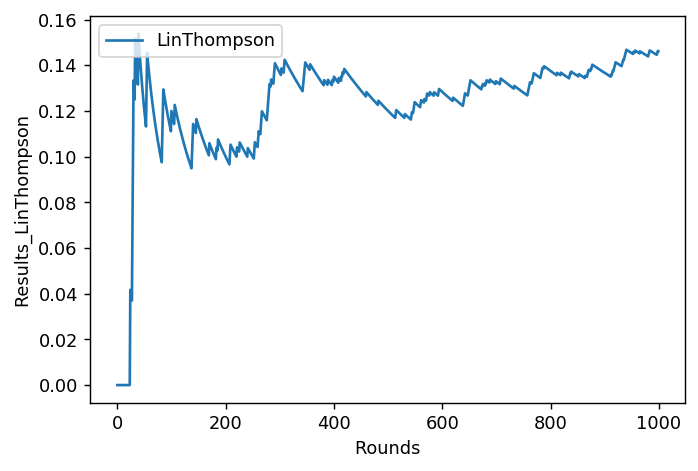

In [80]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, test_arms, test_rewards, test_contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=1000,params={'lin_thompson':1.0})

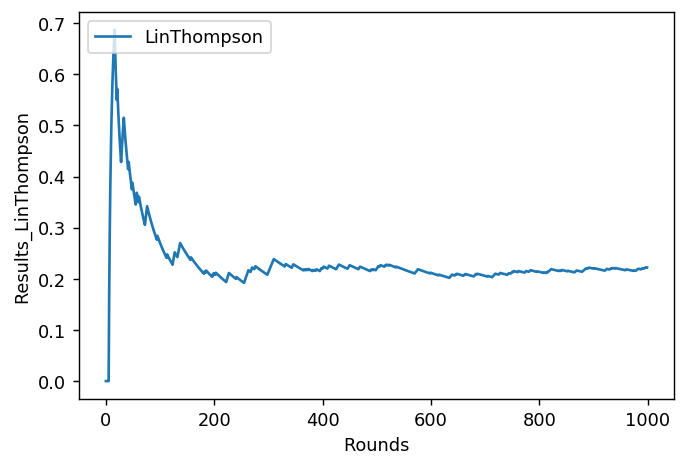

In [81]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, train_arms, train_rewards, train_contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=1000,params={'lin_thompson':1.0})

# 에발루에이션

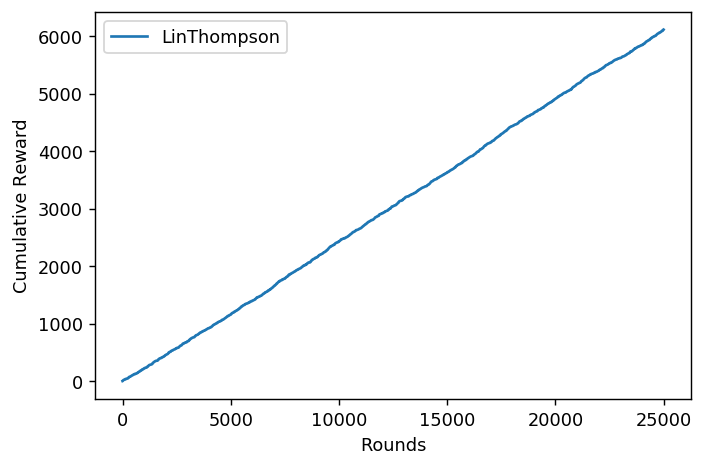

In [23]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]

    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_cumulative)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Reward')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=25000,params={'lin_thompson':1.0})

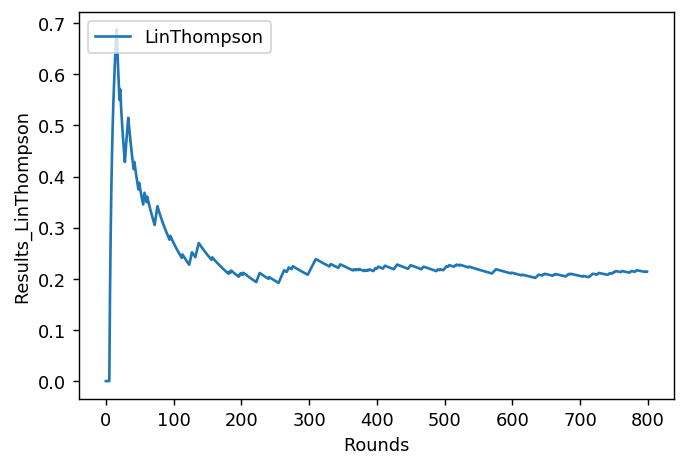

In [34]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=800,params={'lin_thompson':1.0})

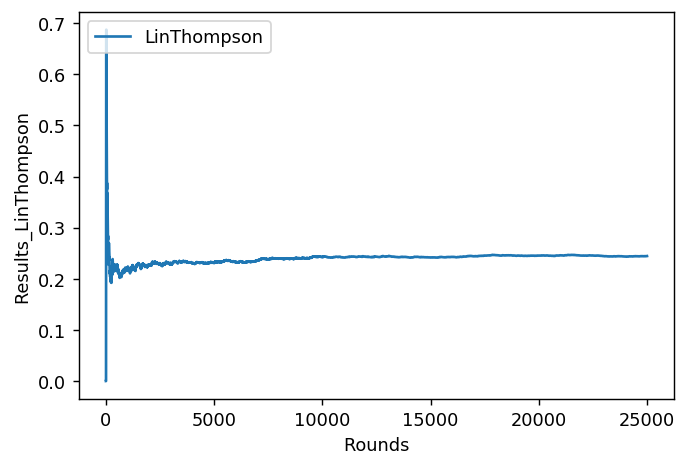

In [35]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=25000,params={'lin_thompson':1.0})

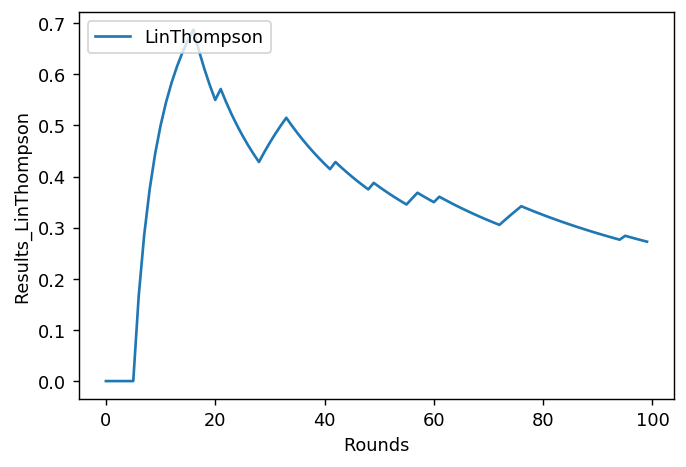

In [36]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=100,params={'lin_thompson':1.0})

In [37]:
train

,product_id,purchase,F/O/0,F/O/1,F/O/2,F/O/3,F/O/4,F/O/5,F/O/6,F/O/7,...,M/N/14,M/N/15,M/N/16,M/N/17,M/N/18,M/N/19,M/N/20,M/N/21,M/N/22,M/N/23
4,17,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,5,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,22,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148607,10,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1148608,10,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1148609,10,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1148610,3,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
train_shuffle = train.sample(frac=1).reset_index(drop=True)

In [43]:
# get arms from dataset
arms = train_shuffle.iloc[:,0].astype('int').values
# get rewards from dataset
rewards = train_shuffle.iloc[:,1].astype('float').values
# get contexts from dataset 
contexts = train_shuffle.iloc[:,2:].astype('float').values

In [44]:
mab = LinThompson(24, 4, 1.0)
results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.27625


In [45]:
for i in range(801):
    mab = LinThompson(24, 4, 1.0)
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, i+1)
    print(str(i+1) + ': LinThompson average reward', np.mean(results_LinThompson))

1: LinThompson average reward 1.0
2: LinThompson average reward 0.5
3: LinThompson average reward 0.3333333333333333
4: LinThompson average reward 0.5
5: LinThompson average reward 0.4
6: LinThompson average reward 0.3333333333333333
7: LinThompson average reward 0.2857142857142857
8: LinThompson average reward 0.25
9: LinThompson average reward 0.2222222222222222
10: LinThompson average reward 0.2
11: LinThompson average reward 0.18181818181818182
12: LinThompson average reward 0.25
13: LinThompson average reward 0.23076923076923078
14: LinThompson average reward 0.2857142857142857
15: LinThompson average reward 0.3333333333333333
16: LinThompson average reward 0.3125
17: LinThompson average reward 0.35294117647058826
18: LinThompson average reward 0.3333333333333333
19: LinThompson average reward 0.3157894736842105
20: LinThompson average reward 0.3
21: LinThompson average reward 0.2857142857142857
22: LinThompson average reward 0.2727272727272727
23: LinThompson average reward 0.304

KeyboardInterrupt: 

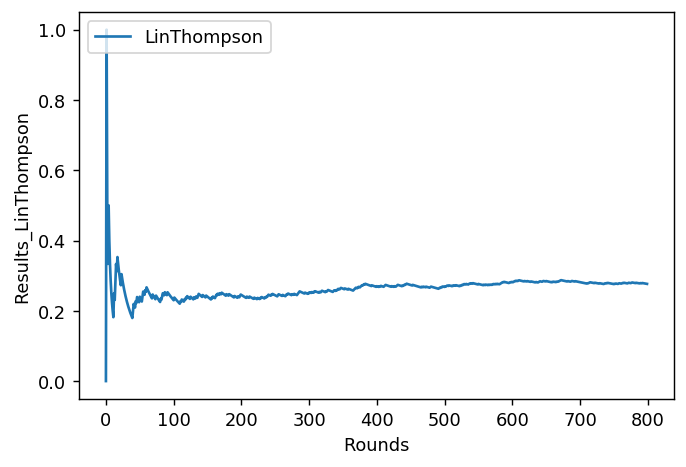

In [48]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameters
    linThompson_cumulative = [0] * T
    linThompson_mean = [0] * T
    
    # Run offline evaluation for algorithms
    # LinThompson
    mab = LinThompson(24, 4, params['lin_thompson'])
    results_LinThompson,me,cov = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]
        linThompson_mean[t] = linThompson_cumulative[t] / t
        
    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_mean)
    plt.legend(['LinThompson'], loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Results_LinThompson')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=800,params={'lin_thompson':1.0})


### Cholesky

In [ ]:
post_beta = stats.multivariate_normal(mean, covariance_matrix)
post_matrix = post_beta.rvs(5)
post_cholesky = np.linalg.cholesky(post_matrix)
clean_mu = np.random.multivariate_normal(mean, covariance_matrix)
noise_mu = np.sqrt(post_cholesky).dot(np.expand_dims(np.random.randn(5),axis=1)).flatten()
samples = clean_mu + noise_mu
sample_mu_tilde = np.expand_dims(samples,axis=1)